# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import time


from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder,  LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, f1_score, confusion_matrix, classification_report, roc_auc_score
#from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC

from sklearn.metrics import RocCurveDisplay

warnings.simplefilter(action='ignore', category=FutureWarning)




In [47]:
bankdata = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [48]:
bankdata.sample(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
8124,38,student,single,university.degree,no,no,no,telephone,jun,mon,...,4,999,0,nonexistent,1.4,94.465,-41.8,4.865,5228.1,no
22659,52,admin.,single,university.degree,no,yes,no,cellular,aug,fri,...,4,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
32844,28,blue-collar,married,basic.6y,no,no,no,cellular,may,mon,...,3,999,0,nonexistent,-1.8,92.893,-46.2,1.299,5099.1,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [49]:
bankdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [50]:
bankdata.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [51]:
# Check for duplicates
duplicate_rows = bankdata.duplicated().sum()
print(f'Number of duplicate rows: {duplicate_rows}')

# Remove duplicate rows
bankdata = bankdata.drop_duplicates()
print(f'Dataset shape after removing duplicates: {bankdata.shape}')

# Check for null values
null_values = bankdata.isnull().sum()
print(f'Null values in each column:\n{null_values}')

Number of duplicate rows: 12
Dataset shape after removing duplicates: (41176, 21)
Null values in each column:
age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64


In [52]:
# remove pdays and previous columns that have the samee value in all the rows
bankdata = bankdata.drop(['pdays', 'previous'], axis=1)

In [53]:
# Find outliers in the data using the IQR method
numerical_columns = bankdata.select_dtypes(include=['int64', 'float64']).columns

df_numerical = bankdata[numerical_columns]

Q1 = df_numerical.quantile(0.25)
Q3 = df_numerical.quantile(0.75)
IQR = Q3 - Q1

total_outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR))).sum()
print(f'Outliers in each column:\n{total_outliers}')

outliers = ((df_numerical < (Q1 - 1.5 * IQR)) | (df_numerical > (Q3 + 1.5 * IQR)))

# Remove outliers from the dataset
print(f'Original dataset shape: {bankdata.shape}')
bankdata = bankdata[~outliers.any(axis=1)]
print(f'Cleaned dataset shape: {bankdata.shape}')


Outliers in each column:
age                468
duration          2963
campaign          2406
emp.var.rate         0
cons.price.idx       0
cons.conf.idx      446
euribor3m            0
nr.employed          0
dtype: int64
Original dataset shape: (41176, 19)
Cleaned dataset shape: (35165, 19)


In [54]:
# review the values in the categorical columns 

for column in bankdata.select_dtypes(include='object').columns:
    print(f"Unique values in {column}: {bankdata[column].unique()}\n")

Unique values in job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Unique values in marital: ['married' 'single' 'divorced' 'unknown']

Unique values in education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Unique values in default: ['no' 'unknown' 'yes']

Unique values in housing: ['no' 'yes' 'unknown']

Unique values in loan: ['no' 'yes' 'unknown']

Unique values in contact: ['telephone' 'cellular']

Unique values in month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Unique values in day_of_week: ['mon' 'tue' 'wed' 'thu' 'fri']

Unique values in poutcome: ['nonexistent' 'failure' 'success']

Unique values in y: ['no' 'yes']



## EDA

<Axes: xlabel='y', ylabel='Count'>

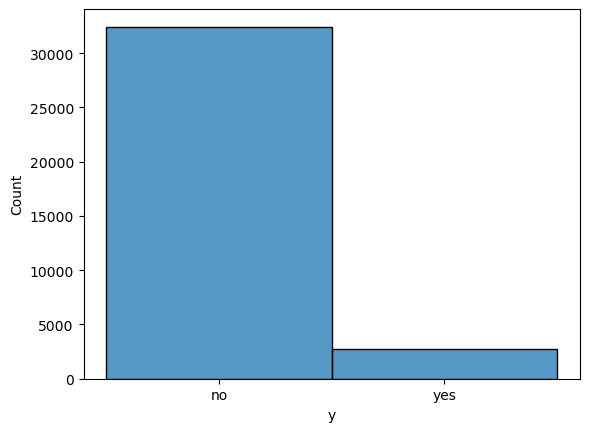

In [55]:
# Examine the distribution of the target variable

sns.histplot(bankdata['y'])

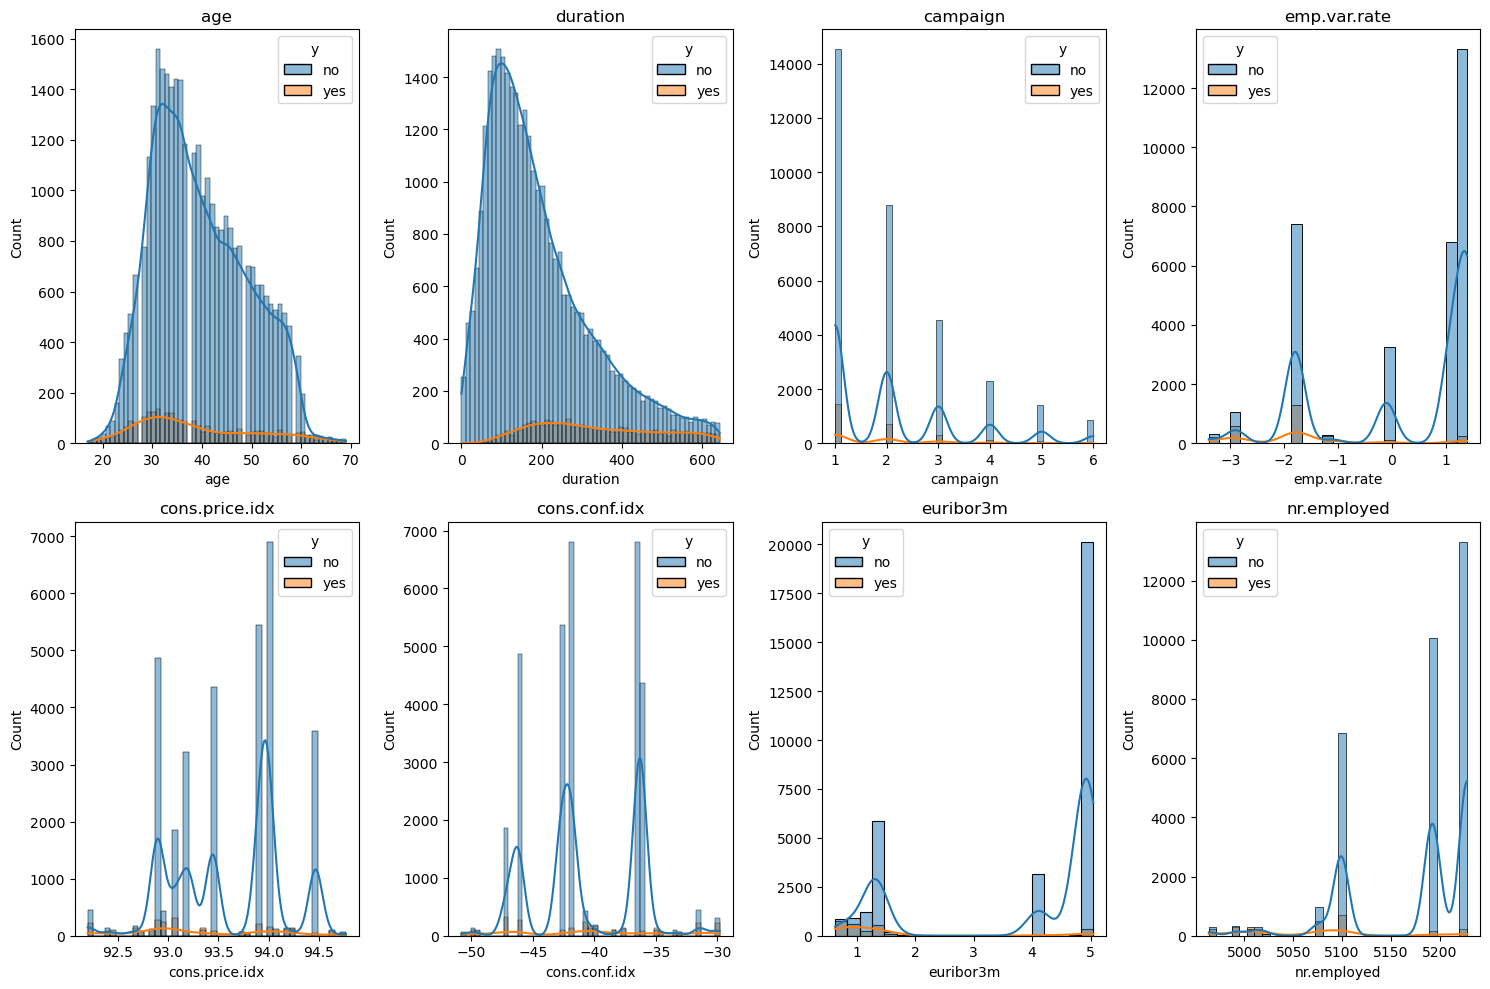

In [57]:
# Plot the distribution of numerical columns

num_cols = 4        # Define the number of rows and columns for the grid
num_rows = (len(numerical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    sns.histplot(x=bankdata[column], ax=axes[i], hue=bankdata['y'], kde=True)
    axes[i].set_title(f'{column}')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Distributions of Numerical Columns**

- **Age**: Age is centered around 40
- **Duration**: customers with larger durations of the last contact call appear to have higher success rates

<Axes: xlabel='y', ylabel='duration'>

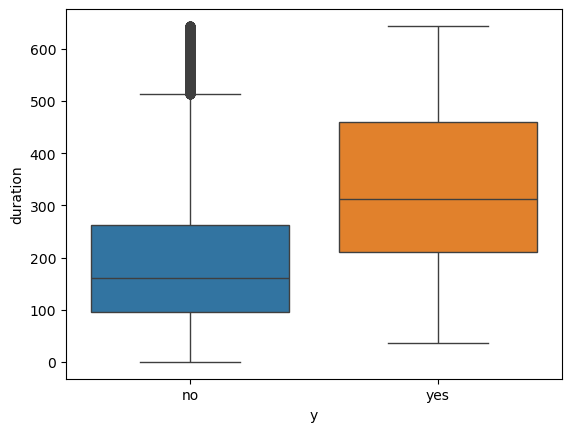

In [58]:

# compare duration column with the target variable

sns.boxplot(y=bankdata['duration'], x=bankdata['y'], hue=bankdata['y'])

**Compare duration of call with success**

- **Duration**: As provided in the guideline the duration of the last contact call in this campaign does have a positive corelation to the success of the compaign

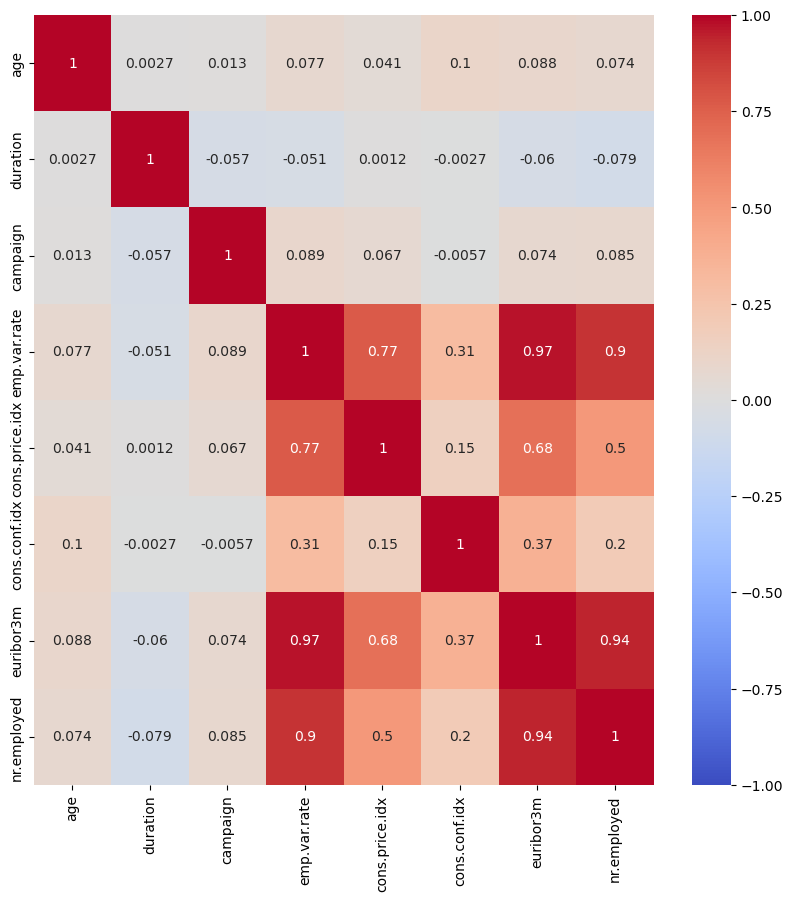

In [59]:
# Review the correlation between numerical columns

plt.figure(figsize=(10, 10))
ax = sns.heatmap(bankdata.corr(numeric_only=True), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

**Examine colinearity of various numerical columns**

The societal numerical features - emp.var.rate, consumer price index, consumer confidence index are highly correlated to each other. On the flip side, as expected they have no correlation to the client information (age) or campaign info(duration, and campaign)

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

# # Define the categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


# # Define the number of rows and columns for the grid
# num_cols = 4
# num_rows = (len(categorical_columns) + num_cols - 1) // num_cols

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# for i, column in enumerate(categorical_columns):
#     sns.countplot(x=column, hue='y', data=bankdata, ax=axes[i])
#     axes[i].set_title(f'{column} vs y')
#     axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

# # Remove any empty subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

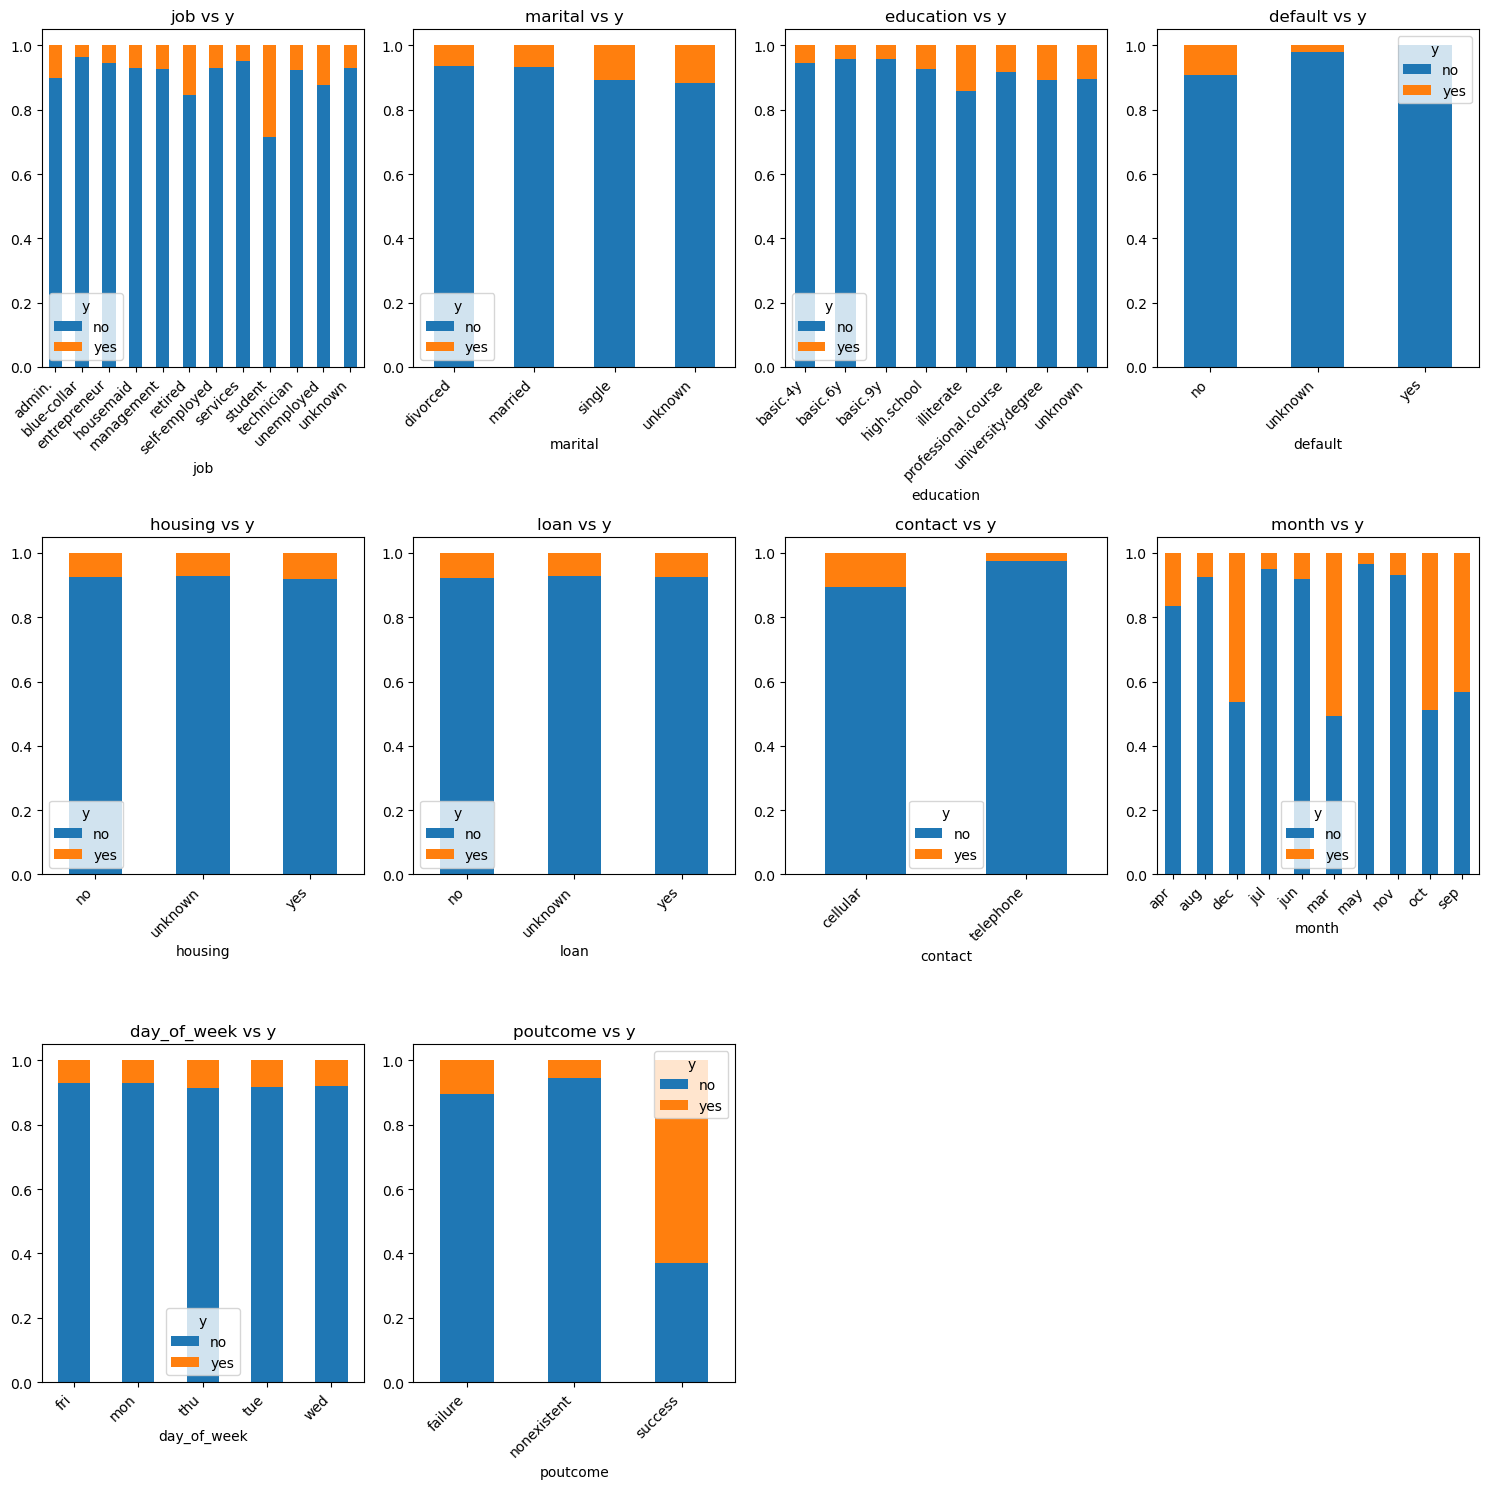

In [61]:
# Examine the categorical variables normalized and compare to the target variable

# Define the categorical columns
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

# Define the number of rows and columns for the grid
num_cols = 4
num_rows = (len(categorical_columns) + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))

# Flatten the axes array for easy iterationa
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    # Calculate the ratio
    ratio = bankdata.groupby([column, 'y']).size().unstack().apply(lambda x: x / x.sum(), axis=1)
    ratio.plot(kind='bar', stacked=True, ax=axes[i])
    axes[i].set_title(f'{column} vs y')
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

**Categorical variables**

- Campaign calls appear to have higher success with customers who are 
    - illterate, or
    - calls made in dec, jun, sept, oct months
    - calls made on mobiles
    - calls made to students or retired



<Axes: xlabel='month', ylabel='count'>

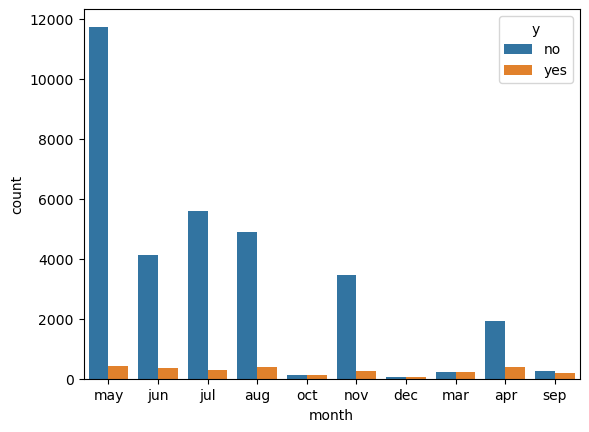

In [62]:
# compare the number of calls made across months, to see if the highest number of calls are made in months with high chance of success

sns.countplot(x='month', hue='y', data=bankdata)

It is interesting to observe that the months with the highest sucess rates, have the least number of calls being made

y                no  yes
month marital           
mar   divorced   15   23
      married   106   89
      single    108  124
      unknown     1    1


<Axes: xlabel='month,marital'>

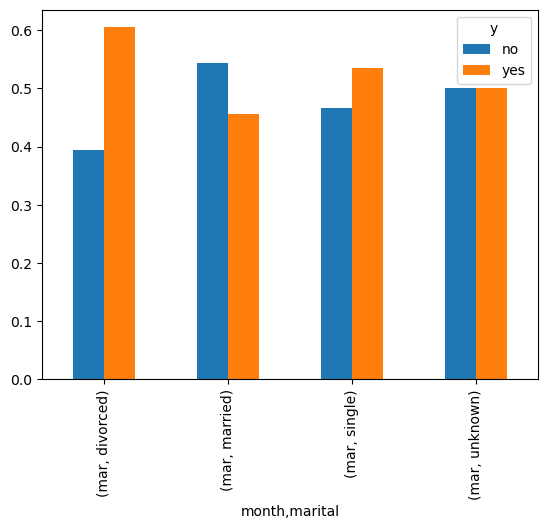

In [63]:
# check distribution of y across marital status in the months where the ratio of success is higher i.e. say Mar

higher_months = ['mar']

bankdata_higher_months   = bankdata[bankdata['month'].isin(higher_months)]

ratio = bankdata_higher_months.groupby(['month', 'marital','y']).size().unstack()

print(ratio)
ratio.apply(lambda x: x / x.sum(), axis=1).plot(kind='bar')

**Success rate with calls made in Mar, across marital status**

When we look at months with high success rates such as March, within that we observe that success rate is higher with divorced and single customers

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

### Business Objective
Create a machine learning model that can help predict success rates for calls made during a marketing campaign. Determine which attributes of cuustomer, campaign or social/economic attributes have the highest influence on the success

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [64]:
X = bankdata.drop(columns = 'y')
y = bankdata['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((28132, 18), (7033, 18))

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [65]:
from sklearn.dummy import DummyClassifier

In [66]:
dc = DummyClassifier(strategy='most_frequent').fit(X_train, y_train)
dc.score(X_test, y_test)

0.9272003412484005

### Problem 7b: Simple Models



In [69]:
transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), categorical_columns),
                                     remainder = StandardScaler())
pipelines = {
    'lr': Pipeline([('transform', transformer), ('classifier', LogisticRegression())]),
    'knn': Pipeline([('transform', transformer), ('classifier', KNeighborsClassifier())]),
    'dt': Pipeline([('transform', transformer), ('classifier', DecisionTreeClassifier())]),
    'svm': Pipeline([('transform', transformer), ('classifier', SVC())])
}

scores = {}
for model_name, pipeline in pipelines.items():
    start_time = time.time()
    pipeline.fit(X_train, y_train.values.ravel())
    score = cross_val_score(pipeline, X_train, y_train.values.ravel(), cv=5, scoring='accuracy').mean()
    scores[model_name] = score
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    print(f"{model_name} with accuracy score {score:.3f}, took {elapsed_time:.3f} seconds")
    
    

lr with accuracy score 0.938
Time Taken 0.792
knn with accuracy score 0.932
Time Taken 27.726
dt with accuracy score 0.919
Time Taken 1.796
svm with accuracy score 0.940
Time Taken 41.850


### Problem 8: A Simple Model - knn

Use Logistic Regression to build a basic model on your data.  

In [ ]:
from sklearn.compose import make_column_transformer
from sklearn.neighbors import KNeighborsClassifier

transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), categorical_columns),
                                     remainder = StandardScaler())

transformer.fit(X_train, y_train)
transformer.get_feature_names_out()


In [21]:
knn_pipe = Pipeline([('transform', transformer), ('knn', KNeighborsClassifier())])
knn_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('knn', KNeighborsClassifier())])

In [ ]:
roc_grid = GridSearchCV(estimator=knn_pipe, param_grid={'knn__n_neighbors': range(6, 30, 4)}, scoring='roc_auc')
roc_grid.fit(X_train, y_train)
best_k = roc_grid.best_params_['knn__n_neighbors']
roc_grid.best_params_, roc_grid.best_score_

KeyboardInterrupt: 

In [325]:
y_pred = roc_grid.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.9381487274278402
Macro-Precision: 0.7984299221722079
Macro-Recall: 0.6579849296982825
Macro-F1 Score: 0.702266724240569


In [329]:

# Encode the target variable
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
pred_encoded = le.transform(y_pred)

fpr, tpr, thresh_rocs = roc_curve(y_test_encoded, pred_encoded)
roc_curve(y_test_encoded, pred_encoded)

# Answer check
print('False Positive Rates: ', fpr[:5])
print('True Positive Rates: ', tpr[:5])


[0 0 0 ... 0 0 0]
False Positive Rates:  [0.         0.01410827 1.        ]
True Positive Rates:  [0.         0.33007812 1.        ]


### Problem 8: A Simple Model - Logistic Regression

Use Logistic Regression to build a basic model on your data.  

In [334]:
log_pipe = Pipeline([('transform', transformer), ('lr', LogisticRegression())])
log_pipe.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('lr', LogisticRegression())])

In [335]:
y_pred = log_pipe.predict(X_test)

In [378]:
# evaluate performance
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='macro')
precision = precision_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print('Accuracy: {}'.format(accuracy))
print('Macro-Precision: {}'.format(precision))
print('Macro-Recall: {}'.format(recall))
print('Macro-F1 Score: {}'.format(f1))

Accuracy: 0.9365846722593488
Macro-Precision: 0.7736174753625008
Macro-Recall: 0.6958366479451004
Macro-F1 Score: 0.7267791005982307


### 8 Decision Tree Model

In [393]:
# params = {'dt__min_impurity_decrease': [0.01, 0.02, 0.03, 0.05],
#          'dt__max_depth': [6,8,10],
#          'dt__min_samples_split': [0.1, 0.2, 0.05]}

params = {'dt__max_depth': [2,4,6,8,10]}

dt_pipe = Pipeline([('transform', transformer), ('dt', DecisionTreeClassifier(random_state = 42))])

dt_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('dt', DecisionTreeClassifier(random_state=42))])

In [ ]:
dt_grid = GridSearchCV(dt_pipe,param_grid=params, cv=5).fit(X_train, y_train)

grid_train_acc = dt_grid.score(X_train, y_train)
grid_test_acc = dt_grid.score(X_test, y_test)
best_params = dt_grid.best_params_
### END SOLUTION

### Answer Check
print(f'Training Accuracy: {grid_train_acc: .2f}')
print(f'Test Accuracy: {grid_test_acc: .2f}')
print(f'Best parameters of tree: {best_params}')

Training Accuracy:  0.95
Test Accuracy:  0.94
Best parameters of tree: {'dt__max_depth': 6}


In [ ]:
### BEGIN SOLUTION
dt = dt_grid.best_estimator_.named_steps['dt']

depth_1 = export_text(dt, feature_names=dt_grid.best_estimator_.named_steps['transform'].get_feature_names_out())

### END SOLUTION

### ANSWER CHECK
print(depth_1)

### 8 SVM

In [404]:
params = {'svm__kernel': ['rbf', 'poly', 'linear', 'sigmoid'],
         'svm__gamma': [0.1, 1.0, 10.0],}

svm_pipe = Pipeline([('transform', transformer), ('svm', SVC(random_state = 42))])

svm_pipe

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('svm', SVC(random_state=42))])

In [ ]:
### GRADED
grid = GridSearchCV(svm_pipe, param_grid = params).fit(X_train, y_train)
grid_score = grid.score(X_test, y_test)


### ANSWER CHECK
print(grid_score)

### Problem 9: Score the Model

What is the accuracy of your model?

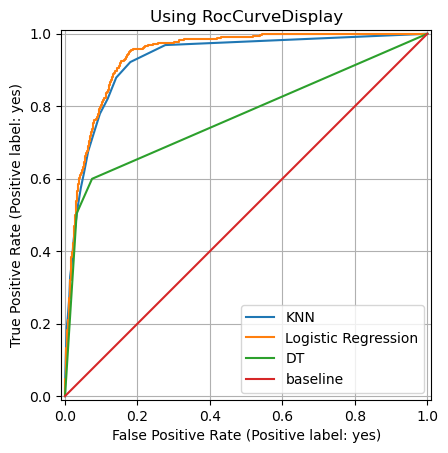

In [387]:
fig, ax = plt.subplots()
RocCurveDisplay.from_estimator(roc_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = 'KNN')
RocCurveDisplay.from_estimator(log_pipe, X_test, y_test, pos_label = 'yes', ax = ax, label = 'Logistic Regression')
RocCurveDisplay.from_estimator(dt_grid, X_test, y_test, pos_label = 'yes', ax = ax, label = 'DT')
plt.grid()
plt.plot(np.arange(0, 1.1, .1), np.arange(0, 1.1, .1), label = 'baseline');
plt.title('Using RocCurveDisplay')
plt.legend();

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions